## 철새 수 위험도 테이블


In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
#지우파일 시도-시군구-year-month-철새수 데이터 파일 불러오기

df894=pd.read_csv("./data/month_local.csv")
month_local_br=df894.copy()
month_local_br.head()

,시도,시군구,year,month,철새수
0,강원도,철원군,2014,10,51660
1,강원도,철원군,2014,11,43900
2,강원도,철원군,2014,12,9336
3,강원도,철원군,2015,1,10857
4,강원도,철원군,2015,2,14109


In [3]:
month_local_br['시도']=month_local_br['시도'].map(lambda x: x.replace(" ",""))

In [4]:
#발생건수 데이터 불러오기 #2015년~2020년만 가져오기
AI=pd.read_csv("HPAIOccurlist_final_v2.csv")
AI_occur_m=AI.copy()
AI_occur_m=AI_occur_m.query('2014 < year and year < 2021')

In [5]:
AI_occur_m['발생건수']=1
AI_occur_m.head()

,발생일,지역코드,시도,시군구,year,month,day,발생건수
1,20170103,211,강원도,인제군,2017,1,3,1
2,20161209,95,강원도,철원군,2016,12,9,1
3,20161130,95,강원도,철원군,2016,11,30,1
6,20170106,114,강원도,횡성군,2017,1,6,1
8,20170303,99,경기도,고양시,2017,3,3,1


In [6]:
철새수=np.round(month_local_br.groupby(['시도','month'])['철새수'].mean(),0)
birds=철새수.to_frame()

In [7]:
birds.head()

철새수
시도  month        
강원도 1      4259.0
    2      2801.0
    3      2801.0
    10     3031.0
    11     3381.0

In [8]:
#발생건수 '시도' '시군' 별 카운트
AI_occur_local_m=AI_occur_m.groupby(['시도','month'])['발생건수'].count()
AI_occur_local_m=AI_occur_local_m.to_frame()

In [9]:
AI_occur_local_m.head()

발생건수
시도  month      
강원도 1         2
    11        1
    12        1
경기도 1        34
    2         7

In [10]:
#발생건수 '시도' '시군' 별 카운트
AI_occur_local_si=AI_occur_m.groupby(['시도','month'])['발생건수'].sum()
AI_occur_local_si=AI_occur_local_si.to_frame()
AI_occur_local_si.reset_index(inplace=True)
temp=[]
for n1, group in AI_occur_m.groupby(['시도','month']):
    temp.append(len(set(group['시군구'].values)))

In [11]:
len(temp)

54

In [12]:
AI_occur_local_m['시군구수']=temp

In [13]:
AI_occur_local_m.head()

발생건수  시군구수
시도  month            
강원도 1         2     2
    11        1     1
    12        1     1
경기도 1        34    11
    2         7     3

In [14]:
birds.index[0]

('강원도', 1)

In [15]:
AI_occur_local_m.index[0]

('강원도', 1)

In [16]:
# 발생건수 합계
AI_occur_local_m['평균발생건수']=np.round(AI_occur_local_m['발생건수']/AI_occur_local_m['시군구수'],2)

In [17]:
AI_occur_local_m['평균철새수']=0.0
for index in birds.index:
    AI_occur_local_m.loc[index,'평균철새수']=birds.loc[index,'철새수']

In [18]:
AI_occur_local_m=AI_occur_local_m.fillna(0)

In [19]:
AI_occur_local_m=AI_occur_local_m.sort_index()

In [20]:
AI_occur_local_m.head()

발생건수  시군구수  평균발생건수   평균철새수
시도  month                            
강원도 1       2.0   2.0     1.0  4259.0
    2       0.0   0.0     0.0  2801.0
    3       0.0   0.0     0.0  2801.0
    10      0.0   0.0     0.0  3031.0
    11      1.0   1.0     1.0  3381.0

In [21]:
AI_occur_local_m.to_csv("철새수_년도월_발생건수.csv", encoding='utf-8-sig')

In [22]:
import joblib
r_model=joblib.load('model/birds_regression.pkl')

In [23]:
AI_occur_local_m['평균철새수'].values.reshape(-1,1)[:10]

array([[4259.],
       [2801.],
       [2801.],
       [3031.],
       [3381.],
       [5241.],
       [4931.],
       [3820.],
       [4500.],
       [   0.]])

In [24]:
AI_occur_local_m['평균예측발생건수']=np.round(r_model.predict(AI_occur_local_m['평균철새수'].values.reshape(-1,1)),1)

In [35]:
AI_occur_local_m['risk']=AI_occur_local_m['평균예측발생건수'].rank(method='dense', ascending=True)

In [38]:
max(AI_occur_local_m['risk'])

20.0

In [39]:
AI_occur_local_m['risk']=np.round(AI_occur_local_m['risk']/2,1)

In [40]:
AI_occur_local_m.head()

발생건수  시군구수  평균발생건수   평균철새수  평균예측발생건수  발생비율   순위  risk
시도  month                                                       
강원도 1       2.0   2.0     1.0  4259.0       1.8  0.56  7.0   3.5
    2       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    3       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    10      0.0   0.0     0.0  3031.0       1.7  0.00  6.0   3.0
    11      1.0   1.0     1.0  3381.0       1.7  0.59  6.0   3.0

In [42]:
AI_occur_local_m.to_csv("birds_risk_table_final.csv", encoding='utf-8-sig')

In [101]:
AI_occur_local_m.corr()

,발생건수,시군구수,평균발생건수,평균철새수,평균예측발생건수,발생비율,순위,risk
발생건수,1.000000,0.765669,0.683822,0.106879,0.098293,0.608377,0.155120,0.155120
시군구수,0.765669,1.000000,0.445662,0.092291,0.084702,0.409760,0.155926,0.155926
평균발생건수,0.683822,0.445662,1.000000,0.056118,0.055842,0.971731,0.092795,0.092795
평균철새수,0.106879,0.092291,0.056118,1.000000,0.999052,-0.049323,0.961090,0.961090
평균예측발생건수,0.098293,0.084702,0.055842,0.999052,1.000000,-0.048969,0.962336,0.962336
발생비율,0.608377,0.409760,0.971731,-0.049323,-0.048969,1.000000,-0.029464,-0.029464
순위,0.155120,0.155926,0.092795,0.961090,0.962336,-0.029464,1.000000,1.000000
risk,0.155120,0.155926,0.092795,0.961090,0.962336,-0.029464,1.000000,1.000000


In [51]:
from sklearn import linear_model

In [61]:
AI_occur_local_m['평균철새수'].values.reshape(-1,1)

array([ 4259.,  2801.,  2801.,  3031.,  3381.,  5241.,  4931.,  3820.,
        4500.,     0.,     0.,     0.,  4237.,  5136.,  5726.,  2263.,
         879.,   366.,     0.,   601.,  1083.,  2478.,  3442.,  2015.,
        1035.,   539.,  1074.,  3453.,  2377.,   871.,   245.,     0.,
         185.,   372.,  1950.,  2429.,   359.,     0.,     0.,     0.,
           0.,  2555., 14687., 11121.,  6236.,     0.,  5932., 14885.,
       13240.,  2262.,  1242.,  2106.,   373.,   940.,  2429.,  3949.,
        5721.,  2510.,   459.,  1078.,  3870., 24755., 13212.,  4901.,
           0.,   254.,  6211., 22589.,  4375.,   653.,    73.,     0.,
           0.,  5737.,  3459.,  1709.,   721.,     0.,     0.,     0.,
           0.,   464.,  2679.,  6975., 11514.,  4492.,  1147.,     0.,
           0.,  1376.,  2932.,  6272.,  5236.,  2739.,  1367.,     0.,
         370.,  1581.,  4354., 13756.,  9720.,  4819.,     0.,  5978.,
        7708., 11175.,  3375.,  2316.,  1696.,   849.,  2136.,  3369.])

In [63]:
regr=linear_model.LinearRegression()
x=AI_occur_local_m['평균철새수'].values.reshape(-1,1)
y=AI_occur_local_m['평균발생건수'].values.reshape(-1,1)
regr.fit(x, y)

LinearRegression()

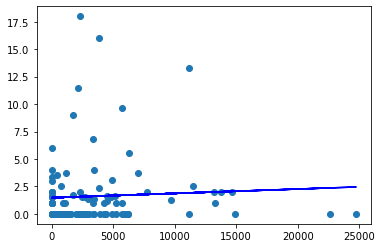

In [64]:
plt.scatter(x,y)
plt.plot(x,regr.predict(x), c='blue')
plt.show()

# x축=철새수
# y축=발생건수

In [78]:
print("A_value:",regr.intercept_) #세로축
print("B_value:",regr.coef_) #기울기

A_value: [1.47612993]
B_value: [[3.94318925e-05]]


In [73]:
residuals=AI_occur_local_m['평균발생건수']-AI_occur_local_m['평균예측발생건수']
residuals.describe()

count    112.000000
mean      -0.098125
std        3.149929
min       -4.800000
25%       -1.500000
50%       -1.200000
75%       -0.012500
max       16.400000
dtype: float64

In [102]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49373 missing from c

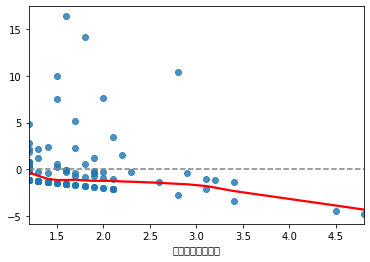

In [104]:
sns.regplot(AI_occur_local_m['평균예측발생건수'],residuals,lowess=True, line_kws={'color':'red'})
plt.plot([AI_occur_local_m['평균예측발생건수'].min(),AI_occur_local_m['평균예측발생건수'].max()],[0,0],'--',color='grey')

In [75]:
# SSE 오차제곱합
SSE=(residuals**2).sum()
SSE

1102.4263

In [79]:
# SST 총변동 (SSR+SSE)
SST=((AI_occur_local_m['평균발생건수']-AI_occur_local_m['평균발생건수'].mean())**2).sum()
SST

1080.2212276785715

In [81]:
# 결정계수
R_squared=1-(SSE/SST)
R_squared

-0.02055604144083345

In [ ]:
# linear 모델 불가 # 선형성이 없고, 상관관계도 없고, 비모수적이다.

In [99]:
# 분류모델 활용

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [106]:
AI_occur_local_m.head()

발생건수  시군구수  평균발생건수   평균철새수  평균예측발생건수  발생비율   순위  risk
시도  month                                                       
강원도 1       2.0   2.0     1.0  4259.0       1.8  0.56  7.0   3.5
    2       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    3       0.0   0.0     0.0  2801.0       1.6  0.00  5.0   2.5
    10      0.0   0.0     0.0  3031.0       1.7  0.00  6.0   3.0
    11      1.0   1.0     1.0  3381.0       1.7  0.59  6.0   3.0

In [116]:
train_data=AI_occur_local_m['평균철새수'].values
target_data=AI_occur_local_m['평균발생건수'].values

In [119]:
train_data[:10]

array([4259., 2801., 2801., 3031., 3381., 5241., 4931., 3820., 4500.,
          0.])

In [120]:
target_data[:10]

array([1.  , 0.  , 0.  , 0.  , 1.  , 1.  , 3.09, 2.33, 1.2 , 1.5 ])

In [124]:
# target_data one-hot-encoding
target_data2 = pd.get_dummies(list(target_data))

In [125]:
target_data2.head()

,0.00,1.00,1.20,1.25,1.33,1.50,1.67,1.75,2.00,2.33,...,4.00,5.57,6.00,6.83,9.00,9.64,11.50,13.25,16.00,18.00
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
train_x, test_x, train_y, test_y = train_test_split(train_data.reshape(-1,1), target_data2, test_size = 0.2, random_state = 42)

In [132]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_x,train_y)

RandomForestClassifier(random_state=42)

In [133]:
predict1 = clf.predict(test_x)
print(accuracy_score(test_y,predict1))

0.34782608695652173


In [ ]:
## 분류모델은 의미 없는 듯

In [134]:
from scipy import stats

In [144]:
db=AI_occur_local_m[['평균발생건수','평균철새수']]

In [146]:
db=db.sort_values("평균발생건수")

In [147]:
db.head()

평균발생건수  평균철새수
시도    month               
강원도   1         0.0    0.0
광주광역시 9         0.0  464.0
      10        0.0  539.0
      11        0.0  601.0
      12        0.0  653.0

In [149]:
stats.spearmanr(db['평균발생건수'].values,db['평균철새수'].values) # 철새수와 발생건수는 강한 양의 상관관계가 성립한다.

SpearmanrResult(correlation=0.9301004266286962, pvalue=1.1590920367127312e-49)